<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SAM_Point_Prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!pip -q install opencv-python-headless matplotlib
!pip -q install bitsandbytes transformers accelerate peft

  Preparing metadata (setup.py) ... done


In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-03-13 17:30:31--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.31, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   184MB/s    in 28s     

2025-03-13 17:30:59 (88.9 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



Download Kitti Sementation Dataset

In [5]:
!gdown 1EB9JSbcQIqjwI5wc8idMWEjmL3CRhh2D
!unzip -q kitti_autonomous_driving_seg.zip

Downloading...
From (original): https://drive.google.com/uc?id=1EB9JSbcQIqjwI5wc8idMWEjmL3CRhh2D
From (redirected): https://drive.google.com/uc?id=1EB9JSbcQIqjwI5wc8idMWEjmL3CRhh2D&confirm=t&uuid=507d0147-8ed5-473c-ba67-10184d4664ed
To: /content/kitti_autonomous_driving_seg.zip
100% 163M/163M [00:03<00:00, 51.6MB/s]


Prepare Dataset and Dataloader:

In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Class names for visualization
class_names = [
    "unlabeled", "ego vehicle", "rectification border", "out of roi", "static", "dynamic", "ground", "road",
    "sidewalk", "parking", "rail track", "building", "wall", "fence", "guard rail", "bridge", "tunnel", "pole",
    "polegroup", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck",
    "bus", "caravan", "trailer", "train", "motorcycle", "bicycle"
]

class KITTISegmentationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_files = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(self.masks_dir) if f.endswith('.png')])

        # Define resize transformation for both image and mask
        self.target_size=(256, 512)
        self.image_transform = transforms.Compose([
            transforms.Resize(self.target_size),  # Resize image
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Load as grayscale

        image = self.image_transform(image)
        mask = mask.resize((self.target_size[1], self.target_size[0]), resample=Image.NEAREST)

        # Convert mask to tensor without scaling
        mask = torch.from_numpy(np.array(mask)).long()
        return image, mask

# Initialize dataset and dataloader
dataset_train = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/train')
dataset_test = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/test')
dataloader_train = DataLoader(dataset_train, batch_size=12, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)
print('training sample:', len(dataset_train), 'testing sample:', len(dataset_test))
print('1st sample shape:',dataset_train[0][0].shape, 'classes inside masks:', dataset_train[0][1].unique())

training sample: 171 testing sample: 20
1st sample shape: torch.Size([3, 256, 512]) classes inside masks: tensor([ 4,  7,  8, 11, 12, 13, 17, 20, 21, 23, 24, 26, 27, 28])


#Validating point prompt with center point of the classes: sky or road

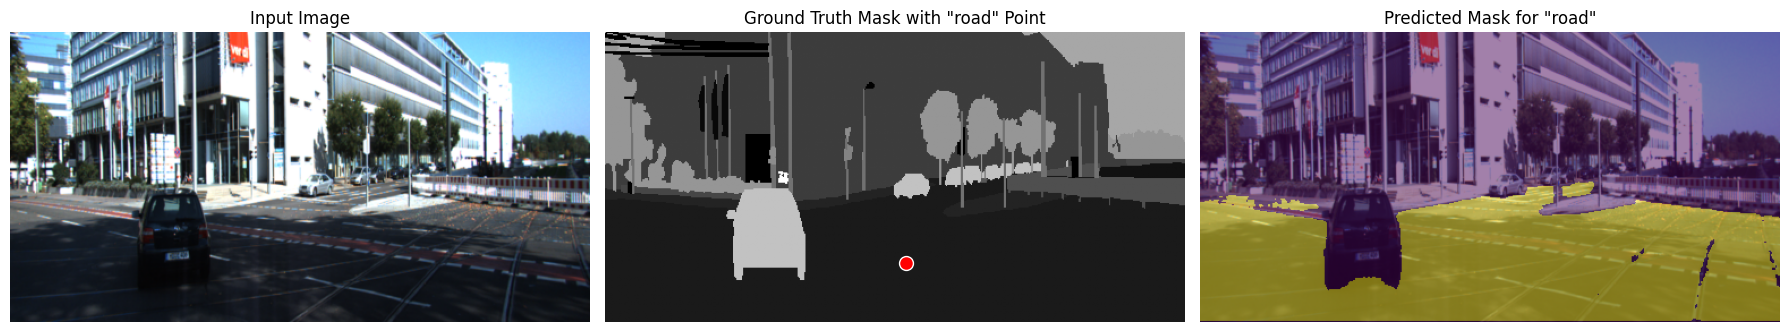

In [23]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
import matplotlib.pyplot as plt

# Load SAM model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Download from SAM GitHub release page
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

# Class names for visualization
class_names = [
    "unlabeled", "ego vehicle", "rectification border", "out of roi", "static", "dynamic", "ground", "road",
    "sidewalk", "parking", "rail track", "building", "wall", "fence", "guard rail", "bridge", "tunnel", "pole",
    "polegroup", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck",
    "bus", "caravan", "trailer", "train", "motorcycle", "bicycle"
]


# Function to extract point prompt from specific class in the ground truth mask
def get_point_prompt_from_class(mask, class_name):
    class_index = class_names.index(class_name)
    mask_np = mask.cpu().numpy()

    # Find coordinates of the target class
    target_points = np.argwhere(mask_np == class_index)
    if len(target_points) == 0:
        return None, None

    # Get center point of the target class region
    y, x = np.mean(target_points, axis=0).astype(int)
    point = np.array([[x, y]])  # Format: [[x, y]]
    label = np.array([1])  # 1 = Foreground
    return point, label

# Load dataset and dataloader (for validation)
dataset_test = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/test')
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Get a batch of data from the validation dataloader
images, masks = next(iter(dataloader_test))

# Extract image and mask
image = images[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for SAM
mask = masks[0]

# 🔥 Specify the target class ('car' or 'road')
target_class = "road"  # Change to "road" if needed
point, label = get_point_prompt_from_class(mask, target_class)

if point is not None:
    # Run SAM prediction
    predictor.set_image(image)
    masks, _, _ = predictor.predict(
        point_coords=point,
        point_labels=label,
        multimask_output=False  # Get a single best mask
    )

    # ---- Visualization ----
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Input Image
    axes[0].imshow(image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Ground Truth Mask with Point Overlay
    axes[1].imshow(mask.cpu().numpy(), cmap='gray')
    axes[1].scatter(
        point[0][0], point[0][1],  # x, y coordinates
        color='red', s=100, marker='o', edgecolors='white'
    )
    axes[1].set_title(f'Ground Truth Mask with "{target_class}" Point')
    axes[1].axis('off')

    # Predicted Mask from SAM (WITHOUT Point Overlay)
    axes[2].imshow(image)
    axes[2].imshow(masks[0], alpha=0.5, cmap='viridis')
    axes[2].set_title(f'Predicted Mask for "{target_class}"')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print(f"No valid points found for class '{target_class}'.")


#Validating point prompt with random point of the classes: sky or road

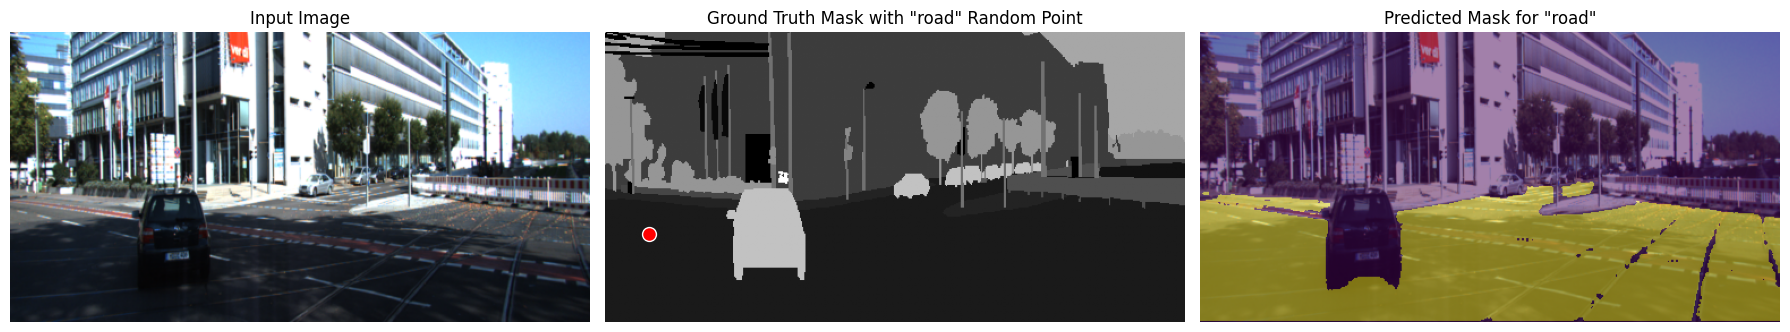

In [24]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
import matplotlib.pyplot as plt

# Load SAM model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Download from SAM GitHub release page
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

# Class names for visualization
class_names = [
    "unlabeled", "ego vehicle", "rectification border", "out of roi", "static", "dynamic", "ground", "road",
    "sidewalk", "parking", "rail track", "building", "wall", "fence", "guard rail", "bridge", "tunnel", "pole",
    "polegroup", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck",
    "bus", "caravan", "trailer", "train", "motorcycle", "bicycle"
]

# Function to extract a random point prompt from the target class in the mask
def get_random_point_from_class(mask, class_name):
    class_index = class_names.index(class_name)
    mask_np = mask.cpu().numpy()

    # Find coordinates of the target class
    target_points = np.argwhere(mask_np == class_index)
    if len(target_points) == 0:
        return None, None

    # Select a random point from the target class region
    random_idx = np.random.choice(len(target_points))
    y, x = target_points[random_idx]

    point = np.array([[x, y]])  # Format for SAM: [[x, y]]
    label = np.array([1])  # 1 = Foreground
    return point, label

# Load dataset and dataloader (for validation)
dataset_test = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/test')
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Get a batch of data from the validation dataloader
images, masks = next(iter(dataloader_test))

# Extract image and mask
image = images[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for SAM
mask = masks[0]

# 🔥 Specify the target class ('sky' or 'road')
target_class = "road"  # Change to "sky" if needed
point, label = get_random_point_from_class(mask, target_class)

if point is not None:
    # Run SAM prediction
    predictor.set_image(image)
    masks, _, _ = predictor.predict(
        point_coords=point,
        point_labels=label,
        multimask_output=False  # Get a single best mask
    )

    # ---- Visualization ----
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Input Image
    axes[0].imshow(image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Ground Truth Mask with Random Point Overlay
    axes[1].imshow(mask.cpu().numpy(), cmap='gray')
    axes[1].scatter(
        point[0][0], point[0][1],  # x, y coordinates
        color='red', s=100, marker='o', edgecolors='white'
    )
    axes[1].set_title(f'Ground Truth Mask with "{target_class}" Random Point')
    axes[1].axis('off')

    # Predicted Mask from SAM (WITHOUT Point Overlay)
    axes[2].imshow(image)
    axes[2].imshow(masks[0], alpha=0.5, cmap='viridis')
    axes[2].set_title(f'Predicted Mask for "{target_class}"')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print(f"No valid points found for class '{target_class}'.")


#SAM LoRA finetuning for sky and road only with point prompt

In [8]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from peft import LoraConfig, get_peft_model
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image

# ✅ Load SAM model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to(device)

# ✅ Apply LoRA for Efficient Fine-Tuning
config = LoraConfig(
    r=8,                        # Lower rank to save memory
    lora_alpha=16,              # Lower alpha for better stability
    target_modules=["qkv", "proj"]
)
sam = get_peft_model(sam, config)

# ✅ Set up predictor
predictor = SamPredictor(sam)

# ✅ Class names for Kitti
class_names = [
    "unlabeled", "ego vehicle", "rectification border", "out of roi", "static", "dynamic", "ground", "road",
    "sidewalk", "parking", "rail track", "building", "wall", "fence", "guard rail", "bridge", "tunnel", "pole",
    "polegroup", "traffic light", "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck",
    "bus", "caravan", "trailer", "train", "motorcycle", "bicycle"
]

# ✅ Get index for 'sky' and 'road'
sky_class = class_names.index("sky")
road_class = class_names.index("road")

# ✅ Dataset class with point prompt generation
class KITTISegmentationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_files = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(self.masks_dir) if f.endswith('.png')])

        # Define resize transformation for both image and mask
        self.target_size = (256, 512)
        self.image_transform = transforms.Compose([
            transforms.Resize(self.target_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        # Transform
        image = self.image_transform(image)
        mask = mask.resize((self.target_size[1], self.target_size[0]), resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()

        # ✅ Get point prompt from the ground truth mask
        point, label = self.get_random_point_from_class(mask)
        return image, mask, point, label

    def get_random_point_from_class(self, mask):
        mask_np = mask.cpu().numpy()

        # ✅ Randomly select between 'sky' and 'road'
        target_class = sky_class if np.random.rand() > 0.5 else road_class

        # ✅ Find coordinates of the target class
        target_points = np.argwhere(mask_np == target_class)
        if len(target_points) == 0:
            return None, None

        # ✅ Randomly select a point from the target class region
        y, x = target_points[np.random.choice(len(target_points))]
        point = np.array([[x, y]])  # Format for SAM: [[x, y]]
        label = np.array([1])  # 1 = Foreground
        return point, label

# ✅ Load dataset and dataloader
dataset_train = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/train')
dataset_test = KITTISegmentationDataset(root_dir='kitti_autonomous_driving_seg/test')
dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=False)

# ✅ Set up optimizer
optimizer = torch.optim.AdamW(sam.parameters(), lr=1e-4, weight_decay=1e-5)

# ✅ Define BCE loss
bce_loss = torch.nn.BCEWithLogitsLoss()

# ✅ Training function
def train_one_epoch(model, predictor, dataloader, optimizer):
    model.train()
    total_loss = 0
    total_iou = 0
    num_samples = 0

    for images, masks, points, labels in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        for i in range(images.size(0)):
            if points[i] is not None:
                predictor.set_image(images[i].permute(1, 2, 0).cpu().numpy())

                # ✅ Convert to numpy
                point_coords = points[i].cpu().numpy()
                point_labels = labels[i].cpu().numpy()

                outputs, _, _ = predictor.predict(
                    point_coords=point_coords,
                    point_labels=point_labels,
                    multimask_output=False
                )

                # ✅ Convert numpy to tensor and enable gradients
                pred = torch.from_numpy(outputs[0]).to(device).float().requires_grad_()
                target = (masks[i] == road_class).float()

                # ✅ Compute IoU
                intersection = (pred.argmax(dim=0) * target).sum()
                union = (pred.argmax(dim=0) + target).clamp(0, 1).sum()
                iou = intersection / union if union > 0 else torch.tensor(0.0).to(device)

                # ✅ BCE Loss
                loss = bce_loss(pred.unsqueeze(0), target.unsqueeze(0))
                loss.backward()

                total_loss += loss.item()
                total_iou += iou.item()
                num_samples += 1

        optimizer.step()

    mean_loss = total_loss / num_samples
    mean_iou = total_iou / num_samples
    return mean_loss, mean_iou

# ✅ Validation function
def validate(model, predictor, dataloader):
    model.eval()
    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for images, masks, points, labels in dataloader:
            images, masks = images.to(device), masks.to(device)

            for i in range(images.size(0)):
                if points[i] is not None:
                    predictor.set_image(images[i].permute(1, 2, 0).cpu().numpy())

                    point_coords = points[i].cpu().numpy()
                    point_labels = labels[i].cpu().numpy()

                    outputs, _, _ = predictor.predict(
                        point_coords=point_coords,
                        point_labels=point_labels,
                        multimask_output=False
                    )

                    pred = torch.from_numpy(outputs[0]).to(device).float()
                    target = (masks[i] == road_class).float()

                    intersection = (pred.argmax(dim=0) * target).sum()
                    union = (pred.argmax(dim=0) + target).clamp(0, 1).sum()
                    iou = intersection / union if union > 0 else torch.tensor(0.0).to(device)

                    total_iou += iou.item()
                    num_samples += 1

    return total_iou / num_samples

# ✅ Training Loop
best_iou = 0
best_epoch = 0
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_iou = train_one_epoch(sam, predictor, dataloader_train, optimizer)
    val_iou = validate(sam, predictor, dataloader_test)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f}")

    if val_iou > best_iou:
        best_iou = val_iou
        best_epoch = epoch + 1
        torch.save(sam.state_dict(), "best_sam_lora.pth")

print(f"\n✅ Best Epoch: {best_epoch}, Best IoU: {best_iou:.4f}")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>